# 现代循环神经网络
 首先，读取时间机器数据集

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import funcs


batch_size, num_steps = 32, 35
num_hiddens = 512
device = "cuda:0"
train_iter, vocab = funcs.load_data_time_machine(batch_size, num_steps)

## 门控循环单元（GRU）
### 从零开始实现

重置门 $ R_t = \sigma (X_t W_{xr} + H_{t-1}W_{hr}+b_r ) $

更新门 $ Z_t = \sigma (X_t W_{xz} + H_{t-1}W_{hz}+b_z ) $ 

候选隐状态 $ \tilde{H_t} = tanh(X_{t}W_{xh} + (R_t \odot H_{t-1}) W_{hh} + b_h ) $

隐状态 $H_t = Z_t \odot H_{t-1} + (1 - Z_t) \odot \tilde{H_t} $

- 每当更新门 $Z_t$ 接近 $1$ 时，模型就倾向只保留旧状态。 此时，来自 $X_t$ 的信息基本上被忽略， 从而有效地跳过了依赖链条中的时间步 $t$ 。 相反，当 $Z_t$ 接近 $0$ 时， 新的隐状态 $H_t$ 就会接近候选隐状态 $\tilde{H_t}$ 。

In [2]:
# 获取初始参数：Wxr, Whr, br, Wxz, Whz, bz, Wxh, Whh, bh
def get_gru_params(embed_size:int, num_hiddens:int, device:str):
    """获取GRU中的所有参数:
    `W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q`
    """
    num_inputs = num_outputs = embed_size
    def wwb():
        return (torch.randn((num_inputs, num_hiddens), device=device)/100,
                torch.randn((num_hiddens, num_hiddens), device=device)/100,
                torch.zeros((num_hiddens), device=device),
        )
    W_xz, W_hz, b_z = wwb()
    W_xr, W_hr, b_r = wwb()
    W_xh, W_hh, b_h = wwb()
    W_hq = torch.randn((num_hiddens, num_outputs), device=device)/100
    b_q  = torch.zeros((num_outputs), device=device)
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_gru_state(batch_size, num_hiddens, device):
    """ 初始化隐变量 """
    return torch.zeros((batch_size, num_hiddens), device=device)

In [3]:
def gru_forward(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H = state
    outputs = []
    for x in inputs:
        Z = torch.sigmoid((x @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((x @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((x @ W_xh) + ((R * H) @ W_hh) + b_h )
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), H

In [4]:
para  = get_gru_params(len(vocab), num_hiddens, device)
state = init_gru_state(2, num_hiddens, device)
x     = torch.ones((5,2,len(vocab)), device=device, dtype=torch.float)

y, state = gru_forward(x, state, para)
y.shape, state.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x28 and 4598x512)

In [5]:
gru = funcs.RNN(
    len(vocab), num_hiddens, device, get_gru_params, init_gru_state, gru_forward
)
funcs.rnn_predict("time ", 50, gru, vocab, device, True)

'time theirs anachronism expression scepticism ashamed novelty million ruins frames inflicted parent parent greyish failed framed abstractions branches blindness stretched fatigued avoided casting postal chain vegetation maddened instance turfy ceiling fascination method minds tattered crackling longing unsympathetic joint mild thousands shape shiver stare hectic tramps ferns emotions breeding bench connubial pile '

  0%|          | 0/800 [00:00<?, ?it/s]

困惑度[1.15], 速度[16601.3 词元/秒], 设备[cuda:0]
time traveller it would be remarkably convenient for the historian the psychologist suggested one might travel back and verify the accepted account of the battle of hastings for instance don t you think you would attract attention said the medical man our ancestors had no great tolerance for anachronisms one might get 
traveller holding the lamp aloft i intend to explore time is that plain i was never more serious in my life none of us quite knew how to take it i caught filby s eye over the shoulder of the medical man and he winked at me solemnly iii the time 


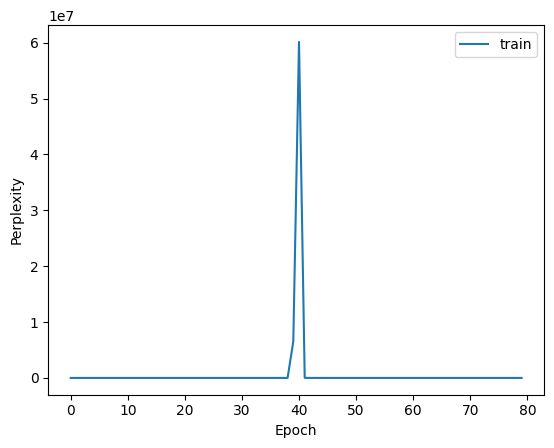

In [6]:
num_epochs = 800
num_hiddens = 1024
lr = 5e-3
gru = funcs.RNN(
    len(vocab), num_hiddens, device, get_gru_params, init_gru_state, gru_forward
)
# opt = torch.optim.SGD(gru.parameters(), lr, momentum=0.9)
opt = torch.optim.Adam(gru.parameters(), lr)
ppls = funcs.train_rnn(gru, num_epochs, train_iter, opt, device, tqdm)
pred_fn = lambda prefix: funcs.rnn_predict(prefix, 50, gru, vocab, device, True)
print(pred_fn('time traveller'))
print(pred_fn('traveller'))

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.plot(ppls)
plt.legend(["train"])

### 使用高级API实现

In [22]:
class RNN(nn.Module):
    def __init__(self, layer:nn.RNN, device="cuda:1"):
        super().__init__()
        self.device = device
        self.layer = layer
        self.out_layer = nn.Linear(layer.hidden_size, layer.input_size, device=device)
    
    def forward(self, x:torch.Tensor, state:torch.Tensor):
        x = x.long().to(self.device)
        x = F.one_hot(x, self.layer.input_size).to(torch.float)
        y, state = self.layer(x, state)
        # y:[t,b,embed]  ->  [t*b, embed]
        out = self.out_layer(y.reshape((-1, self.layer.hidden_size)))
        return out, state
    
    def begin_state(self, batch_size:int, device:str):
        return torch.zeros((1, batch_size, self.layer.hidden_size), 
                            dtype=torch.float, device=device)
        

In [17]:
gru_layer = nn.GRU(len(vocab), num_hiddens, device=device)
model = RNN(gru_layer, device=device)
